# Layer Class

In [27]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class layer: 
    def forward(self, input):
        raise NotImplementedError            
        
    def backward(self, grad_output):
        raise NotImplementedError

   
       

# Linear Layer

In [28]:
class linear_layer(layer):
    def __init__(self, input_dim, output_dim,activation):
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Xavier initialization for sigmoid
        if(activation == 'sigmoid'):
            self.w = np.random.randn(output_dim, input_dim) * np.sqrt(1.0 / input_dim)
        # He initialization for tanh/ReLU
        elif(activation == 'tanh' or activation == 'relu'):
            self.w = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros(output_dim)
        self.input = None
        # Gradients computed during backward pass
        self.grad_w = None
        self.grad_b = None
    def forward(self, input):
        self.input = input
        return np.dot(input, self.w.T) + self.b

    def backward(self, delta):
        self.grad_w = delta.T.dot(self.input)
        self.grad_b = delta.sum(axis=0)
        grad_input = delta.dot(self.w)  # shape (n, input_dim)
        return grad_input
           

# Sigmoid Activation

In [29]:
class sigmoid_layer(layer):
    def __init__(self):
        self.out = None

    def forward(self, input):
       self.out = 1 / (1 + np.exp(-input))
       return self.out

    def backward(self, delta):
        return delta * self.out * (1 - self.out)

# Tanh Activation

In [30]:
class tanh_layer(layer):
    def __init__(self):
        self.out = None

    def forward(self, input):
        self.out = np.tanh(input)
        return self.out

    def backward(self, delta):
        return delta * (1 - self.out ** 2)

# ReLU Activation

In [31]:
class relu_layer(layer):
    def __init__(self):
        self.input = None

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad_output):
        grad = grad_output.copy()
        grad[self.input <= 0] = 0
        return grad

# Binary Cross-Entropy Loss

In [32]:
class BinaryCrossEntropyLoss(layer):
    def __init__(self):
        self.pred = None
        self.target = None

    def forward(self, pred, target):
        # Clip predictions to avoid log(0)
        self.pred = np.clip(pred, 1e-7, 1 - 1e-7)
        self.target = target
        loss = - (target * np.log(self.pred) + (1 - target) * np.log(1 - self.pred))
        return np.mean(loss)
    
    def backward(self):
        # Compute gradient of BCE loss with respect to predictions.
        grad = (-(self.target / self.pred) + ((1 - self.target) / (1 - self.pred))) / self.target.shape[0]
        return grad

# Mean Squared Error Loss

In [33]:
class MSELoss(layer):
    def __init__(self):
        self.pred = None
        self.target = None

    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        loss = np.mean((pred - target) ** 2)
        return loss

    def backward(self):
        grad = 2 * (self.pred - self.target) / self.target.shape[0]
        return grad

# Sequential Container for Layers

In [34]:
class Sequential(layer):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def save_weights(self, filename):
        # Save weights for layers that have parameters (e.g., Linear layers)
        weights = []
        for layer in self.layers:
            if isinstance(layer, linear_layer):
                weights.append({'w': layer.w, 'b': layer.b})
            else:
                weights.append(None)
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)
        print("Weights saved to", filename)

    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        for layer, w in zip(self.layers, weights):
            if isinstance(layer, linear_layer) and w is not None:
                layer.w = w['w']
                layer.b = w['b']
        print("Weights loaded from", filename)

# Training Loop for Classification Networks

In [35]:
def train(network, loss_layer, X, y, epochs, lr):
    losses = []
    best_loss = float('inf')
    patience = 10  # Number of epochs to wait before stopping
    patience_counter = 0
    for epoch in range(epochs):
        # Forward pass
        pred = network.forward(X)
        loss = loss_layer.forward(pred, y)
        losses.append(loss)
        # Backward pass
        grad_loss = loss_layer.backward()
        network.backward(grad_loss)
        # Update parameters for every Linear layer
        for layer in network.layers:
            if isinstance(layer, linear_layer):
                layer.w -= lr  * layer.grad_w
                layer.b -= lr  * layer.grad_b
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1        
        # Print progress periodically
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    return losses

# Training Loop for Regression with Early Stopping (Taxi Trip Duration)

In [36]:
def train_regression(network, loss_layer, X_train, y_train, X_val, y_val, epochs, lr, patience=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        # --- Training Step ---
        pred_train = network.forward(X_train)
        train_loss = loss_layer.forward(pred_train, y_train)
        train_losses.append(train_loss)
        grad_loss = loss_layer.backward()
        network.backward(grad_loss)
        for layer in network.layers:
            if isinstance(layer, linear_layer):
                layer.w -= lr * layer.grad_w
                layer.b -= lr * layer.grad_b

        # --- Validation Step ---
        pred_val = network.forward(X_val)
        val_loss = loss_layer.forward(pred_val, y_val)
        val_losses.append(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered at epoch", epoch)
            break

        if epoch % 100 == 0:
            print("Epoch {}: Train Loss = {:.4f}, Val Loss = {:.4f}".format(epoch, train_loss, val_loss))
    return train_losses, val_losses

# Demonstration: XOR Problem

In [37]:
def calculate_accuracy(predictions, true_labels):
    # Convert predictions to binary values (0 or 1) using a threshold of 0.5
    binary_predictions = (predictions > 0.5).astype(int)
    # Compare predictions with true labels
    correct_predictions = np.sum(binary_predictions == true_labels)
    
    # Calculate accuracy
    accuracy = (correct_predictions / len(true_labels)) * 100
    return accuracy

def solve_XOR():
    X = np.array([[0,0], [0,1], [1,0], [1,1]]) # XOR input
    Y = np.array([[0], [1], [1], [0]]) # XOR output

    print("Training XOR network with sigmoid activation...")


    network_sigmoid = Sequential([linear_layer(2,2,"sigmoid"), sigmoid_layer(), linear_layer(2,1,"sigmoid"), sigmoid_layer()])
    loss_bce = BinaryCrossEntropyLoss()
    losses_sigmoid = train(network_sigmoid, loss_bce, X, Y, epochs=10000, lr=0.1)

    preds_sigmoid = network_sigmoid.forward(X)
    print("XOR Predictions (Sigmoid):\n", preds_sigmoid)
    
    # Calculate accuracy
    accuracy_sigmoid = calculate_accuracy(preds_sigmoid, Y)
    print(f"Accuracy (Sigmoid): {accuracy_sigmoid:.2f}%")
    # Save the trained weights
    network_sigmoid.save_weights("XOR_solved.w")


    print("Training XOR network with tanh activation...")
    network_tanh = Sequential([linear_layer(2,2,"tanh"), tanh_layer(), linear_layer(2,1,"tanh"), sigmoid_layer()])
    losses_tanh = train(network_tanh, loss_bce, X, Y, epochs=10000, lr=0.1)
    preds_tanh = network_tanh.forward(X)
    print("XOR Predictions (Tanh hidden activation):\n", preds_tanh)
    # Calculate accuracy
    accuracy_tanh = calculate_accuracy(preds_tanh, Y)
    print(f"Accuracy (Tanh): {accuracy_tanh:.2f}%")
    network_tanh.save_weights("XOR_solved_tanh.w")

    plt.figure(figsize=(8,4))
    plt.plot(losses_sigmoid, label="Sigmoid")
    plt.plot(losses_tanh, label="Tanh")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("XOR Training Loss")
    plt.legend()
    plt.show()




# Demonstration: Taxi Trip Duration Prediction

In [38]:
def preprocess_data(data_frame, is_training=True):
    if is_training:
        preprocessed_data = data_frame.dropna()
    else:
        preprocessed_data = data_frame  # No preprocessing for testing data
    return preprocessed_data


def predict_taxi_trip_duration():
    # Load the dataset (make sure the file nyc_taxi_data.npy is in the working directory)
    try:
        dataset = np.load("nyc_taxi_data.npy", allow_pickle=True)
        dataset = dataset.item()
        
    except Exception as e:
        print("Error loading taxi dataset:", e)
        return

    
    X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]
    X_train = preprocess_data(X_train)
    y_train = preprocess_data(y_train)
    X_test = preprocess_data(X_test)
    y_test = preprocess_data(y_test)
    

    #"pickup_datetime","dropoff_datetime"
    # Get indexes of rows where y_train is within the acceptable range
    X_train["pickup_datetime"] =  pd.to_datetime(X_train["pickup_datetime"])
    X_train["dropoff_datetime"] = pd.to_datetime(X_train["dropoff_datetime"])
    X_test["pickup_datetime"] = pd.to_datetime(X_test["pickup_datetime"])
    X_test["dropoff_datetime"] = pd.to_datetime(X_test["dropoff_datetime"])
    
    X_train["pickup_hour"] = X_train["pickup_datetime"].dt.hour
    X_train["pickup_day"] = X_train["pickup_datetime"].dt.day
    X_train["pickup_month"] = X_train["pickup_datetime"].dt.month
    X_test["pickup_hour"] = X_test["pickup_datetime"].dt.hour
    X_test["pickup_day"] = X_test["pickup_datetime"].dt.day
    X_test["pickup_month"] = X_test["pickup_datetime"].dt.month

    X_train["dropoff_hour"] = X_train["dropoff_datetime"].dt.hour
    X_train["dropoff_day"] = X_train["dropoff_datetime"].dt.day
    X_train["dropoff_month"] = X_train["dropoff_datetime"].dt.month
    X_test["dropoff_hour"] = X_test["dropoff_datetime"].dt.hour
    X_test["dropoff_day"] = X_test["dropoff_datetime"].dt.day
    X_test["dropoff_month"] = X_test["dropoff_datetime"].dt.month

    
    # Drop unnecessary columns
    columns_to_drop = ["id", "trip_duration", "store_and_fwd_flag","vendor_id","passenger_count","pickup_datetime","dropoff_datetime"]
    X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
    X_test = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    
    # For this demonstration, we perform a simple normalization.
    feature_scaler = StandardScaler()
    X_train_norm = feature_scaler.fit_transform(X_train)
    X_test_norm = feature_scaler.transform(X_test)
    y_train = np.log1p(y_train)  # Apply log transformation
    y_test = np.log1p(y_test)  # Apply log transformation
   
           
    
    # Split a validation set from training data (80/20 split)
    split = int(0.8 * X_train_norm.shape[0])
    X_train_new, X_val = X_train_norm[:split], X_train_norm[split:]
    y_train_new, y_val = y_train[:split], y_train[split:]
    y_val = np.log1p(y_val)
    
    # Define network configurations

    network_configs = [
         Sequential([linear_layer(X_train_new.shape[1], 64,"relu"), relu_layer(), linear_layer(64, 1,"relu")]),
         Sequential([linear_layer(X_train.shape[1], 32,"relu"), relu_layer(),linear_layer(32, 16,"relu"), relu_layer(), linear_layer(16, 1,"relu")]),
         Sequential([linear_layer(X_train.shape[1], 32,"tanh"), tanh_layer(),linear_layer(32, 16,"tanh"), tanh_layer(), linear_layer(16, 1,"tanh")]),
    ]

    config_titles = [
    "Configuration 1 - 2 Layers",
    "Configuration 2 - 3 Layers",
    "Configuration 3 - 4 Layers"
    ]
    colors = ['b', 'g', 'r']
     
    mse_loss = MSELoss()
    print("\n--- Training Taxi Trip Duration Network ---")
    for config_idx, layers in enumerate(network_configs, 1):
        train_losses, val_losses = train_regression(layers, mse_loss,
                                                X_train_new, y_train_new,
                                                X_val, y_val,
                                                epochs=200, lr=0.01, patience=3)
    
    # Plot training and validation loss curves
        plt.figure(figsize=(8,4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(config_titles[config_idx - 1])
        plt.xlabel("Epochs")
        plt.ylabel("MSE Loss")
        plt.legend()
        plt.show()

     # Evaluate on test set
        test_loss = mse_loss.forward(layers.forward(X_test_norm), y_test)
        print("Test MSE Loss:", test_loss)

     # For RMSLE (Root Mean Squared Logarithmic Error) we can compute:
        pred_test = layers.forward(X_test_norm)
     # Clip predictions to avoid log issues
        pred_test = np.clip(pred_test, 1e-7, None)
        rmsle = np.sqrt(np.mean((np.log1p(pred_test) - np.log1p(y_test))**2))
        print("Test RMSLE:", rmsle)
        
        

# Main Execution


Training XOR network with sigmoid activation...
XOR Predictions (Sigmoid):
 [[0.49453038]
 [0.60508348]
 [0.43906108]
 [0.46092587]]
Accuracy (Sigmoid): 75.00%
Weights saved to XOR_solved.w
Training XOR network with tanh activation...
XOR Predictions (Tanh hidden activation):
 [[0.00246191]
 [0.99563278]
 [0.99559068]
 [0.00211062]]
Accuracy (Tanh): 100.00%
Weights saved to XOR_solved_tanh.w


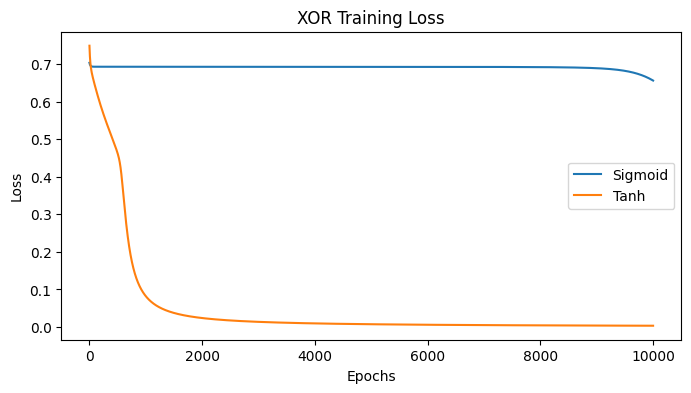


--- Training Taxi Trip Duration Network ---
Epoch 0: Train Loss = 50.2280, Val Loss = 2.5532
Early stopping triggered at epoch 3


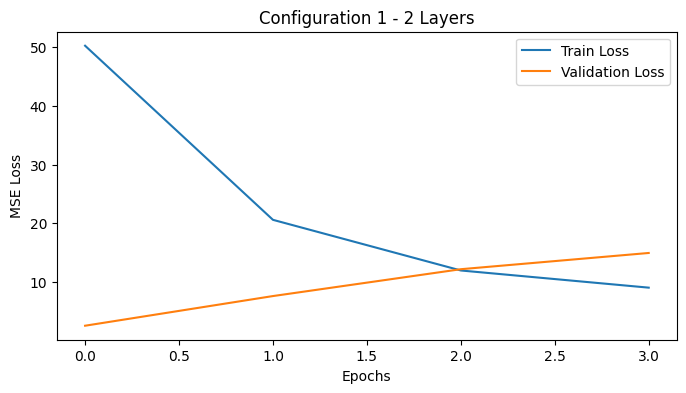

Test MSE Loss: 6.967425378777714
Test RMSLE: 0.4041381404264955
Epoch 0: Train Loss = 57.0703, Val Loss = 1.1521
Early stopping triggered at epoch 3


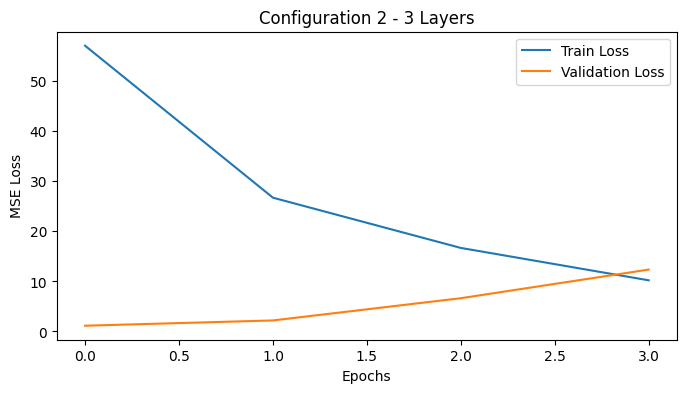

Test MSE Loss: 6.701225955911068
Test RMSLE: 0.40811260619230805
Epoch 0: Train Loss = 43.3515, Val Loss = 3.5068
Early stopping triggered at epoch 8


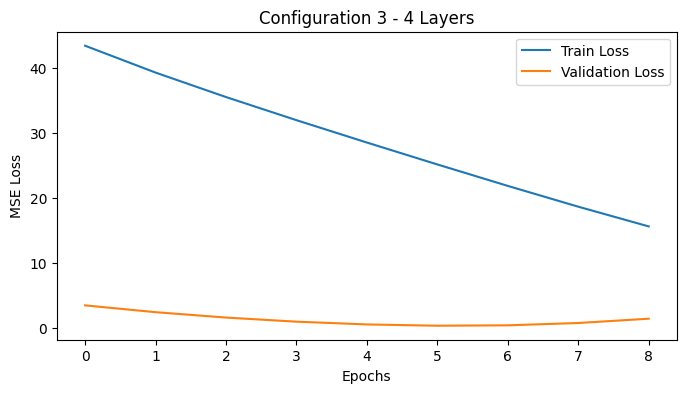

Test MSE Loss: 12.844621716695467
Test RMSLE: 0.6561237706119354


In [39]:
if __name__ == '__main__':
    solve_XOR()
    predict_taxi_trip_duration()

